# Simple sprint workflow
First imports and defining helper functions. No changes should be necessary here.

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import scipy.special
import numpy as np
import pandas as pd
sys.path.append('/project/project_462000451/enchanted-surrogates/submodules/static_sparse_grid_approximations')
sys.path.append('/project/project_462000451/enchanted-surrogates/submodules/tokamak_samplers')

In [2]:
def find_level_for_samples(desired_samples, dimensions):
    total_nodes = 0
    level = 0
    
    while total_nodes < desired_samples:
        nodes_at_level = scipy.special.comb(level + dimensions - 1, dimensions - 1, exact=True)
        total_nodes += nodes_at_level
        
        level += 1
    
    return level

def split_profiles(x_values):
    profiles = []
    current_profile = []
    for i, x in enumerate(x_values):
        if i > 0 and x < x_values[i - 1]:  # Assuming a reset happens when a current psi is less than the previous psi
            profiles.append(current_profile)
            current_profile = []
        current_profile.append(i)
    profiles.append(current_profile)  
    return profiles

def scale_psi_values(x_values, temperatures, profiles):
    scaled_profiles = []
    for profile_indices in profiles:
        # Extract this profile's data
        profile_x = [x_values[i] for i in profile_indices]
        profile_temps = [temperatures[i] for i in profile_indices]
        profile_x_lim = np.array(profile_x)[np.array(profile_x) < 0.95]
        profile_temps_lim = np.array(profile_temps)[np.array(profile_x) < 0.95]
        target_temp_index_lim = min(range(len(profile_temps_lim)), key=lambda k: abs(profile_temps_lim[k] - 100))
        target_x = profile_x_lim[target_temp_index_lim]
        
        # Calculate the shift needed to align this x to 1
        shift = 1 - target_x
        # Apply the shift to all x-values in this profile
        scaled_profile_x = [x + shift for x in profile_x]
        scaled_profiles.append(scaled_profile_x)
    return scaled_profiles

#print(find_level_for_samples(1000, 4))


# Set initial values

Set the preferred sampling method and bounds for the following sampling parameters:

- t_eped: temperature pedestal height 
- n_eped: density pedestal height  
- d_n_ped: density pedestal width   
- d_T_ped: temperature pedestal width 
- n_esep: separatrix density

In [3]:
sampling = 1 # 0 for random sampling, 1 for Static Sparce Grid
num_samples = 15 # if using SSG, it will find the level to get at least this amount of samples

#set the bounds, order t_eped, n_eped, d_n_ped (=d_T_ped), n_esep
bounds = [[1.0, 1.8], [3.0, 4.4], [0.05, 0.1], [0.5, 2.8]]

#set output directory (can be empty or non-empty for analysis)
if sampling == 0:
    base_run_dir = '/scratch/project_462000451/daniel/sprint_out/helena/full_test'
else:
    base_run_dir = '/scratch/project_462000451/daniel/sprint_out/helena/19_2_SSG'
level = find_level_for_samples(num_samples, len(bounds))
print("Level necessary for creating atleast the given number of samples when using SSG =", level)

Level necessary for creating atleast the given number of samples when using SSG = 3


# Static Sparse Grid and Random Grid sampling of HELENA parameters

In [4]:
import numpy as np
sys.path.append('/project/project_462000451/enchanted-surrogates/submodules/static_sparse_grid_approximations')
sys.path.append('/project/project_462000451/enchanted-surrogates_11feb2025/src')
from samplers.static_sparse_grid import StaticSparseGrid

parameters = ['T_eped', 'n_eped', 'd_n_ped', 'd_T_ped', 'n_esep']
parameters_s = ['T_eped', 'n_eped', 'd_n_ped', 'n_esep']
ssg_kargs = {
    'bounds': bounds,
    'level': level,
    'parameters': parameters_s
    }

ssg = StaticSparseGrid(**ssg_kargs)
# add the d_T_ped by duplicating d_n_ped
ssg_set = np.insert(ssg.samples, 3, ssg.samples[:, 2], axis=1)



Cannot find bmdal_reg. Please point to those in your bash script if you intend to use ActiveLearnerBMDAL No module named 'bmdal_reg'
Cannot find DREAM. Please add the $DREAMPATH/py to your PYTHONPATH environment variable before running. No module named 'DREAM'
POINTS SHAPE (15, 4)
 no points for dim = 4 and level = 3 is n = 15


In [5]:
import pandas as pd
df_ssg = pd.DataFrame(ssg_set, columns=parameters)

#num_samples = len(ssg.samples)
#bounds = ssg_kargs['bounds']
data_random = {
    ssg.parameters[i]: np.random.uniform(low=ssg_kargs['bounds'][i][0], high=ssg_kargs['bounds'][i][1], size=num_samples)
    for i in range(len(ssg.parameters))
}
data_random['n_esep'] = np.array([np.random.uniform(low=bounds[3][0], high=min(n_eped - 1.5, bounds[3][1])) for n_eped in data_random['n_eped']])
data_random['d_T_ped'] = data_random['d_n_ped'].copy()
#data_random_set = np.insert(data_random, 3, data_random[:, 2], axis=1)
df_random = pd.DataFrame(data_random)
df_random = df_random[parameters]
random_set = df_random.to_numpy()
print("RANDOM SAMPLING, length", len(random_set))
display(df_random.head())
print("SSG SAMPLING, length", len(ssg_set))
display(df_ssg.head(15))

RANDOM SAMPLING, length 15


,T_eped,n_eped,d_n_ped,d_T_ped,n_esep
0,1.220017,3.949484,0.091456,0.091456,1.646460
1,1.786503,3.230274,0.052903,0.052903,0.716814
2,1.269310,4.299057,0.085845,0.085845,1.929776
3,1.299536,3.754420,0.070651,0.070651,1.024506
4,1.076196,3.077194,0.086581,0.086581,0.595064


SSG SAMPLING, length 15


,T_eped,n_eped,d_n_ped,d_T_ped,n_esep
0,1.4,3.7,0.075,0.075,1.65
1,1.8,3.7,0.075,0.075,1.65
2,1.4,4.4,0.075,0.075,1.65
3,1.4,3.7,0.100,0.100,1.65
4,1.4,3.7,0.075,0.075,2.80
5,1.0,3.7,0.075,0.075,1.65
6,1.8,4.4,0.075,0.075,1.65
7,1.8,3.7,0.100,0.100,1.65
8,1.8,3.7,0.075,0.075,2.80
9,1.4,3.0,0.075,0.075,1.65


# Use or read or make HELENA output directories, run HELENA

In [6]:
from parsers.HELENAparser import HELENAparser
import sys, os
hp = HELENAparser()

sbatch_path = '/project/project_462000451/annaniemela/JET/submit.cmd'
namelist_path = '/projappl/project_462000451/aarojarvinen/hel_test_runt/fort.10'
run_folder_name = '-'.join([str(b) for b in np.array(bounds).flatten()])
hel_output_names = []
if os.path.exists(os.path.join(base_run_dir, run_folder_name)):
    hel_output_names = [name for name in os.listdir(os.path.join(base_run_dir, run_folder_name)) 
                    if os.path.isdir(os.path.join(base_run_dir, run_folder_name, name))]
    print("The following HELENA output directories were found in the folder")
    print(hel_output_names)
    print("If you want to further analyze/use these folders skip the next cell")
    print("If you want to generate more data to the folder, run next cell. It will not create duplicates.")
else:
    print(os.path.join(base_run_dir, run_folder_name))
    print("Given directory does not excist, run HELENA and make the output directories by running the next cell")

The following HELENA output directories were found in the folder
['1.4-3.7-0.07500000000000001-0.07500000000000001-0.5000000000000003', '1.4-4.4-0.07500000000000001-0.07500000000000001-1.65', '1.8-3.7-0.07500000000000001-0.07500000000000001-2.8', '1.8-3.7-0.07500000000000001-0.07500000000000001-1.65', '1.4-3.7-0.07500000000000001-0.07500000000000001-2.8', '1.4-3.7-0.1-0.1-2.8', '1.4-3.7-0.1-0.1-1.65', '1.8-4.4-0.07500000000000001-0.07500000000000001-1.65', '1.4-3.7-0.05000000000000001-0.05000000000000001-1.65', '1.4-3.7-0.07500000000000001-0.07500000000000001-1.65', '1.4-4.4-0.1-0.1-1.65', '1.0-3.7-0.07500000000000001-0.07500000000000001-1.65', '1.4-4.4-0.07500000000000001-0.07500000000000001-2.8', '1.4-3.0-0.07500000000000001-0.07500000000000001-1.65', '1.8-3.7-0.1-0.1-1.65']
If you want to further analyze/use these folders skip the next cell
If you want to generate more data to the folder, run next cell. It will not create duplicates.


### WARNING, running next cell runs HELENA

In [24]:

if sampling == 0:
    sample_set = random_set
    s_tag = 'random'
    print("Running HELENA for n =", len(sample_set), "randomly sampled points")
else:
    sample_set = ssg_set
    s_tag = 'ssg'
    print("Running HELENA for n =", len(sample_set), "SSG sampled points")
for sample in sample_set:
    # hp.write_input_file_noKBM(self, params: dict, run_dir: str, namelist_path: str)
    run_folder_name = '-'.join([str(b) for b in np.array(bounds).flatten()])
    run_dir_name = '-'.join([str(s) for s in sample])
    run_dir_path = os.path.join(base_run_dir, run_folder_name, run_dir_name)
    if os.path.exists(run_dir_path):
        print(f"Skipping sample {sample} because it already exists in {run_dir_path}.")
        continue
    os.system(f'mkdir {run_dir_path} -p')
    os.system(f'cd {run_dir_path} && cp {sbatch_path} ./')
    params = {p: s for p, s in zip(parameters, sample)}
    hp.write_input_file_noKBM(params, run_dir_path, namelist_path)
    os.system(f'cd {run_dir_path} && sbatch submit.cmd')
    hel_output_names.append(run_dir_name)

Running HELENA for n = 15 SSG sampled points
Writing to /scratch/project_462000451/daniel/sprint_out/helena/19_2_SSG/1.0-1.8-3.0-4.4-0.05-0.1-0.5-2.8/1.4-3.7-0.07500000000000001-0.07500000000000001-1.65. Params (europed): {'T_eped': 1.4, 'n_eped': 3.7, 'd_n_ped': 0.07500000000000001, 'd_T_ped': 0.07500000000000001, 'n_esep': 1.65}
neped=3.7, nesep=1.65, teped=1.4, tesep=0.1
fort.10 written to: /scratch/project_462000451/daniel/sprint_out/helena/19_2_SSG/1.0-1.8-3.0-4.4-0.05-0.1-0.5-2.8/1.4-3.7-0.07500000000000001-0.07500000000000001-1.65/fort.10
Submitted batch job 9598942
Writing to /scratch/project_462000451/daniel/sprint_out/helena/19_2_SSG/1.0-1.8-3.0-4.4-0.05-0.1-0.5-2.8/1.8-3.7-0.07500000000000001-0.07500000000000001-1.65. Params (europed): {'T_eped': 1.8, 'n_eped': 3.7, 'd_n_ped': 0.07500000000000001, 'd_T_ped': 0.07500000000000001, 'n_esep': 1.65}
neped=3.7, nesep=1.65, teped=1.8, tesep=0.1
fort.10 written to: /scratch/project_462000451/daniel/sprint_out/helena/19_2_SSG/1.0-1.8

# Validating generated profiles

Plotting the experimental profiles with the profiles from HELENA outputs. Bounds plotted automatically from the folder name. If folder name follows a different format, uncomment line 5 and use the bounds set in the beginning. Can also just give the bounds as a list manually.

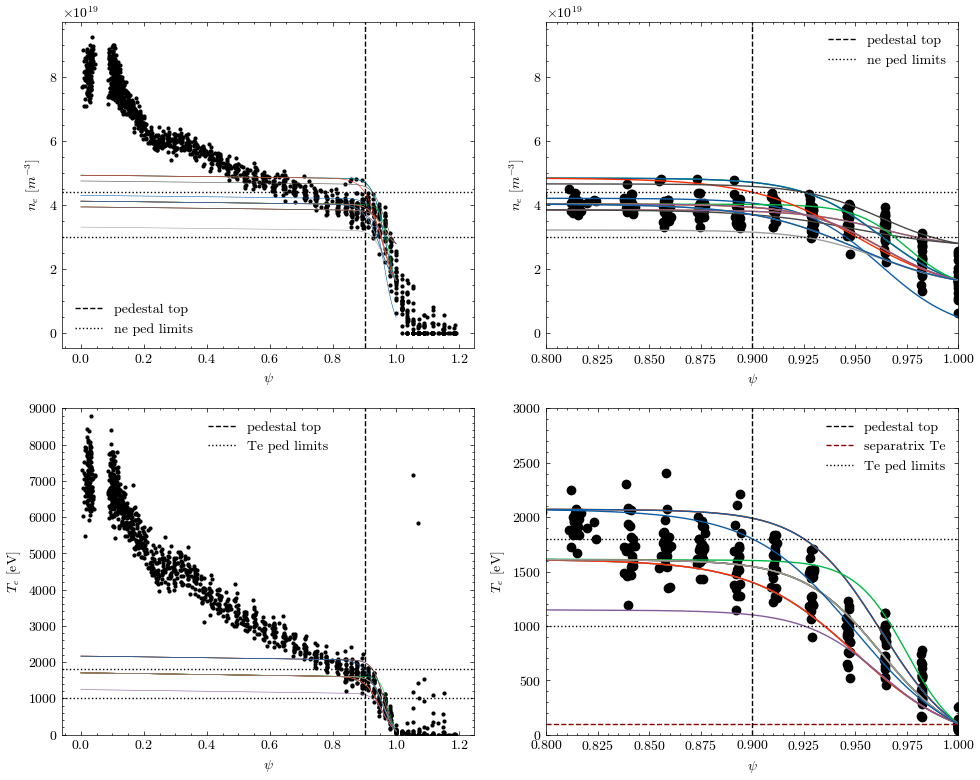

In [7]:
import matplotlib.pyplot as plt
import scienceplots

bounds_folder = [float(num) for num in run_folder_name.split("-")]
#bounds_folder = np.array(bounds).flatten()
plt.style.use(['science','no-latex'])

data = np.loadtxt('/project/project_462000451/annaniemela/JET/JET97781_488_499_psin_ne_te.dat', delimiter=' ')  # Adjust the delimiter if different
prof_split = split_profiles(data[:, 0])
shifted_psi = scale_psi_values(data[:, 0], data[:, 2], prof_split)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for name_path in hel_output_names:
    filepath = os.path.join(base_run_dir, run_folder_name, name_path, "eliteinp")
    elite_data = hp.read_eliteinput(filepath)
    #plt.plot( eliteinp["Psi"], eliteinp["ne"])
    psi = elite_data["Psi"]
    nx = len(psi)
    te = elite_data["Te"]
    ti = elite_data["Ti"]
    ne = elite_data["ne"]
    q = elite_data["q"]
    q_cd = 0.5 * (q[:-1] + q[1:])
    dpsi = np.diff(psi)
    dphit = q_cd * dpsi
    phit = np.cumsum(dphit)
    phitt = np.concatenate(([0], phit))
    rhot = np.sqrt(phitt / np.max(phitt))

    #plt.plot(rhot, elite_data["Te"])
    axs[0, 0].plot(psi/np.max(psi), elite_data["ne"], linewidth=0.4)
    #print(elite_data["Te"][4])
    axs[0, 1].plot(psi/np.max(psi), elite_data["ne"])
    axs[1, 0].plot(psi/np.max(psi), elite_data["Te"], linewidth=0.4)
    axs[1, 1].plot(psi/np.max(psi), elite_data["Te"])


axs[0, 0].scatter(shifted_psi, data[:, 1], color='black', marker='o', s=4)
axs[0, 0].set_xlabel(r'$\psi$')
axs[0, 0].set_ylabel(r'$n_e$ [$m^{-3}$]')
axs[0, 0].axvline(x=1-bounds_folder[5], color='black', linestyle='--', label="pedestal top") 
axs[0, 0].axhline(y=bounds_folder[2]*10**19, color='black', linestyle=':', label = "ne ped limits") 
axs[0, 0].axhline(y=bounds_folder[3]*10**19, color='black', linestyle=':') 
axs[0, 0].legend()


axs[0, 1].scatter(shifted_psi, data[:, 1], color='black', marker='o')
axs[0, 1].set_xlim(0.8, 1)
axs[0, 1].set_xlabel(r'$\psi$')
axs[0, 1].set_ylabel(r'$n_e$ [$m^{-3}$]')
axs[0, 1].axvline(x=1-bounds_folder[5], color='black', linestyle='--', label="pedestal top") 
axs[0, 1].axhline(y=bounds_folder[2]*10**19, color='black', linestyle=':', label = "ne ped limits") 
axs[0, 1].axhline(y=bounds_folder[3]*10**19, color='black', linestyle=':') 
axs[0, 1].legend()

axs[1, 0].scatter(shifted_psi, data[:, 2], color='black', marker='o', s=4)
axs[1, 0].set_ylim(0, 9000)
axs[1, 0].set_xlabel(r'$\psi$')
axs[1, 0].set_ylabel(r'$T_e$ [eV]')
axs[1, 0].axvline(x=1-bounds_folder[5], color='black', linestyle='--', label="pedestal top") 
axs[1, 0].axhline(y=bounds_folder[0]*1000, color='black', linestyle=':', label = "Te ped limits") 
axs[1, 0].axhline(y=bounds_folder[1]*1000, color='black', linestyle=':') 
axs[1, 0].legend()

axs[1, 1].scatter(shifted_psi, data[:, 2], color='black', marker='o')
axs[1, 1].set_xlim(0.8, 1)
axs[1, 1].set_ylim(0, 3000)
axs[1, 1].set_xlabel(r'$\psi$')
axs[1, 1].set_ylabel(r'$T_e$ [eV]')
axs[1, 1].axvline(x=1-bounds_folder[5], color='black', linestyle='--', label="pedestal top") 
axs[1, 1].axhline(y=100, color='darkred', linestyle='--', label = "separatrix Te")  # Vertical dashed line
axs[1, 1].axhline(y=bounds_folder[0]*1000, color='black', linestyle=':', label = "Te ped limits") 
axs[1, 1].axhline(y=bounds_folder[1]*1000, color='black', linestyle=':')
axs[1, 1].legend()
plt.tight_layout()
#fig.suptitle("Bounds = " + bounds_folder, fontsize=8)
#if sampling ==0:
#    fig.suptitle("Random sampling, n_samples =" + len(sample_set), fontsize=8)
#else:
#    fig.suptitle("SSG sampling, n_samples =" + len(sample_set), fontsize=8)
plt.show()

# Generating EQDSK and ITERDB to each sample folder

In [8]:
#sys.path.append('/project/project_462000451/enchanted-surrogates_11feb2025/src')
# The path must be a valid Python path, replacing '-' with '_'
#module_name = "enchanted-surrogates_11feb2025.src.parsers.GENEparser"
#GENEparser = importlib.import_module(module_name).GENEparser
sys.path.append('/project/project_462000451/enchanted-surrogates_11feb2025/submodules')
sys.path.append('/project/project_462000451/enchanted-surrogates_11feb2025/submodules/IFS_scripts')
#sys.path.append('/project/project_462000451/enchanted-surrogates_11feb2025/src')

from parsers.GENEparser import GENEparser
gp = GENEparser()
NR = 1200
NZ = 1200

In [41]:

partest = gp.read_parameters_file("/project/project_462000451/annaniemela/JET/parameters")
print(partest)
print(hel_output_names[5:8])

{'parallelization': {'n_parallel_sims': '1', 'n_procs_sim': '128', 'n_procs_s': '-1', 'n_procs_z': '-1', 'n_procs_w': '-1', 'min_npw': '4', 'max_npw': '8', 'n_procs_v': '-1', 'n_procs_x': '-1', 'n_procs_y': '-1'}, 'box': {'n_spec': '2', 'nx0': '18', 'nky0': '1', 'nz0': '36', 'nv0': '32', 'nw0': '16', 'kymin': '0.10 !scanlist:0.05,0.07', 'lv': '3.1', 'lw': '11', 'x0': '0.97 !scanlist:0.95,0.97', 'kx_center': '0.0', '!lx_a': '0.145', 'adapt_ly': '.T.'}, 'in_out': {'diagdir': "'/scratch/project_462000451/gene_out/out_anna/MAST_U_49108_out/scanfiles0000'", 'read_checkpoint': '.F.', 'istep_nrg': '500', 'istep_field': '2000', 'istep_mom': '2000', '!istep_energy': '200', '!istep_energy3d': '0', 'istep_vsp': '50000', '!istep_neoclass': '0', 'istep_schpt': '5000', 'istep_srcmom': '2000', 'iterdb_file': "'/project/project_462000451/annaniemela/MAST_U_49108/49108_iterdb_1'"}, 'general': {'nblocks': '16', 'perf_vec': '1 1 3 3 1 2 2 1 1', '!nblocks': '32', '!perf_vec': '2 2 2 2 1 1 1 1 1', 'f_versi

First generate EQDSK. Separating these two, due to a crashing problem with lumi. EQDSK is created but iterdb (which uses the eqdsk) is empty. Here implementing Daniel's way to send batch job 

In [32]:
import sys, os
print(hel_output_names[11:13])
for name_path in hel_output_names:
    fpath = os.path.join(base_run_dir, run_folder_name, name_path)
    eqdsk_path = os.path.join(base_run_dir, run_folder_name, name_path, "test2.eqdsk")
    # eqdsk_out = gp.helena_to_eqdsk(fpath, eqdsk_path, NR, NZ)
    os.system(f'sbatch hel_to_eq_submit.cmd {fpath} {eqdsk_path}')

['1.0-3.7-0.07500000000000001-0.07500000000000001-1.65', '1.4-4.4-0.07500000000000001-0.07500000000000001-2.8']
Submitted batch job 9695802
Submitted batch job 9695803
Submitted batch job 9695804
Submitted batch job 9695805
Submitted batch job 9695806
Submitted batch job 9695807
Submitted batch job 9695808
Submitted batch job 9695809
Submitted batch job 9695810
Submitted batch job 9695811
Submitted batch job 9695812
Submitted batch job 9695813
Submitted batch job 9695814
Submitted batch job 9695815
Submitted batch job 9695816


Creating ITERDB to the same folder

In [56]:
for name_path in hel_output_names:
    fpath = os.path.join(base_run_dir, run_folder_name, name_path)
    eqdsk_path = os.path.join(base_run_dir, run_folder_name, name_path, "test2.eqdsk")
    iterdb_path = os.path.join(base_run_dir, run_folder_name, name_path, "iterdb2")
    print(eqdsk_path)
    print(iterdb_path)

    iterdb_out = gp.write_iterdb_profiles(fpath, eqdsk_path, iterdb_path)

/scratch/project_462000451/daniel/sprint_out/helena/19_2_SSG/1.0-1.8-3.0-4.4-0.05-0.1-0.5-2.8/1.4-3.7-0.07500000000000001-0.07500000000000001-0.5000000000000003/test2.eqdsk
/scratch/project_462000451/daniel/sprint_out/helena/19_2_SSG/1.0-1.8-3.0-4.4-0.05-0.1-0.5-2.8/1.4-3.7-0.07500000000000001-0.07500000000000001-0.5000000000000003/iterdb2
EFIT file Resolution: 1200 x 1200
EFIT file Resolution: 1200 x 1200
/scratch/project_462000451/daniel/sprint_out/helena/19_2_SSG/1.0-1.8-3.0-4.4-0.05-0.1-0.5-2.8/1.4-4.4-0.07500000000000001-0.07500000000000001-1.65/test2.eqdsk
/scratch/project_462000451/daniel/sprint_out/helena/19_2_SSG/1.0-1.8-3.0-4.4-0.05-0.1-0.5-2.8/1.4-4.4-0.07500000000000001-0.07500000000000001-1.65/iterdb2
EFIT file Resolution: 1200 x 1200
EFIT file Resolution: 1200 x 1200
/scratch/project_462000451/daniel/sprint_out/helena/19_2_SSG/1.0-1.8-3.0-4.4-0.05-0.1-0.5-2.8/1.8-3.7-0.07500000000000001-0.07500000000000001-2.8/test2.eqdsk
/scratch/project_462000451/daniel/sprint_out/helen

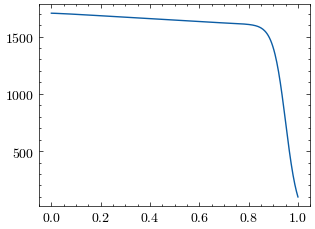

<function matplotlib.pyplot.show(close=None, block=None)>

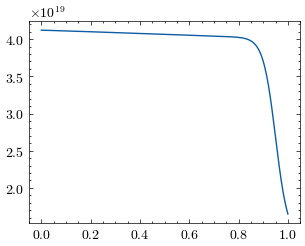

In [46]:
from parsers.HELENAparser import HELENAparser
hp = HELENAparser()
for name_path in hel_output_names[6:7]:
    fpath = os.path.join(base_run_dir, run_folder_name, name_path, "eliteinp")
    eli = hp.read_eliteinput(fpath)
    plt.plot(eli["Psi"]/np.max(eli["Psi"]), eli["Te"])
plt.show()
for name_path in hel_output_names[6:7]:
    fpath = os.path.join(base_run_dir, run_folder_name, name_path, "eliteinp")
    eli = hp.read_eliteinput(fpath)
    plt.plot(eli["Psi"]/np.max(eli["Psi"]), eli["ne"])
plt.show

# Write GENE parameters file for each sample
Creates GENE output directory, writes GENE parameters file and correct sbatch file

In [ ]:
ref_file_path = '/project/project_462000451/annaniemela/JET/parameters'
gene_base_dir = '/scratch/project_462000451/daniel/sprint_out/gene/19_2_SSG'
ky_grid = '0.5 !scanlist:0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0'
#x0_grid = '0.91 !scanlist:0.91,0.93,0.95,0.97,0.99' # TODO, check if we want to change these depending on the pedestal width
x0_grid = [0.94,0.95,0.96,0.97,0.98,0.99]
sbatch_gene_path = '/project/project_462000451/annaniemela/JET/GENE/submit.cmd'

In [ ]:
print(hel_output_names[14:15])
for name_path in hel_output_names[14:15]:
    par_file_path = os.path.join(gene_base_dir, run_folder_name, name_path)
    os.system(f'mkdir {os.path.join(gene_base_dir, run_folder_name)}')
    #os.system(f'mkdir {os.path.join(gene_base_dir, "first_test", run_folder_name, name_path)}')
    eqdsk_path = os.path.join(base_run_dir, run_folder_name, name_path, "test2.eqdsk")
    iterdb_path = os.path.join(base_run_dir, run_folder_name, name_path, "iterdb2")
    par_in_dir = os.path.join(par_file_path, "in_par")
    problemd = os.path.join('/project/project_462000451/gene/', name_path)
    
    sample_folder = [float(num) for num in name_path.split("-")]
    psi_top = 1 - sample_folder[3]
    psi_foot = 1 - 0.1*sample_folder[3]
    psi_mid = (psi_top + psi_foot)/2
    #x0_grid = 
    #TODO, create a gene output dir with par_file_path, make submit.cmd file correct
    #os.system(f'cd /project/project_462000451/gene/ && ./newprob {par_file_path}')
    #UNCOMMENT FOR NEW RUNS
    #os.system(f'cp -r /project/project_462000451/gene/prob_base {problemd}') #something like this but has to create the in_par etc
    #os.system(f'cd /project/project_462000451/gene/prob01 && cp {sbatch_gene_path} ./')
    for x0 in x0_grid:
        par_file_path_2 = os.path.join(gene_base_dir, run_folder_name, name_path, str(x0))
        par_in_dir_2 = os.path.join(par_file_path_2, "in_par")
        problemd_2 = os.path.join('/project/project_462000451/gene/', name_path, str(x0))
        print(problemd_2)
        os.system(f'cp -r /project/project_462000451/gene/prob_base {problemd_2}')
        updates = {
            'in_out': {
                'diagdir':  f"'{par_file_path_2}'",
                'iterdb_file': f"'{iterdb_path}'"
            },
            'box': {
                'kymin': ky_grid,
                'x0': x0, #f"0.94 !scanlist:0.94,0.95,0.96,0.97,0.98,0.99"#{psi_top:.3f},{psi_mid:.3f},{psi_foot:.3f}"
            },
            'geometry': {
                'geomfile': f"'{eqdsk_path}'"
            },
            'scan': {
                'par_in_dir': f"'{par_in_dir_2}'"
            }
        }
        #parameters_path = os.path.join('/project/project_462000451/gene/prob01', "parameters")
        parameters_path = os.path.join(problemd_2, "parameters")
        updated_parameters = gp.write_parameters_file(ref_file_path, parameters_path, updates)
    #os.system(f'mkdir {os.path.join(gene_base_dir, "first_test", run_folder_name, name_path, "in_par")}')

['1.8-3.7-0.1-0.1-1.65']
/project/project_462000451/gene/1.8-3.7-0.1-0.1-1.65/0.94
/project/project_462000451/gene/1.8-3.7-0.1-0.1-1.65/0.95
/project/project_462000451/gene/1.8-3.7-0.1-0.1-1.65/0.96
/project/project_462000451/gene/1.8-3.7-0.1-0.1-1.65/0.97


mkdir: cannot create directory ‘/scratch/project_462000451/daniel/sprint_out/gene/19_2_SSG/1.0-1.8-3.0-4.4-0.05-0.1-0.5-2.8’: File exists


/project/project_462000451/gene/1.8-3.7-0.1-0.1-1.65/0.98
/project/project_462000451/gene/1.8-3.7-0.1-0.1-1.65/0.99


# Run GENE

In [55]:
#TODO, convergence checks? Some timesteps? idk
#TODO what if GENE crashes?
for name_path in hel_output_names[14:15]:
    #par_file_path = os.path.join(gene_base_dir, "first_test", run_folder_name, name_path)
    #os.system(f'cd {par_file_path} && sbatch submit.cmd')
    problemd = os.path.join('/project/project_462000451/gene/', name_path)
    os.system(f'cd {problemd} && sbatch submit.cmd')

Submitted batch job 9696880


# Reading the results

In [12]:
#sys.path.append('../submodules')
#sys.path.append('../submodules/IFS_scripts')
#sys.path.append('../src')

In [11]:
print(sys.path)

['/opt/cray/pe/python/3.11.7/lib/python311.zip', '/opt/cray/pe/python/3.11.7/lib/python3.11', '/opt/cray/pe/python/3.11.7/lib/python3.11/lib-dynload', '', '/scratch/project_462000451/daniel/daniel_sprint/lib/python3.11/site-packages', '/project/project_462000451/enchanted-surrogates/submodules/static_sparse_grid_approximations', '/project/project_462000451/enchanted-surrogates/submodules/tokamak_samplers', '/project/project_462000451/enchanted-surrogates/submodules/static_sparse_grid_approximations', '/project/project_462000451/enchanted-surrogates_11feb2025/src', '/project/project_462000451/enchanted-surrogates_11feb2025/submodules', '/project/project_462000451/enchanted-surrogates_11feb2025/submodules/IFS_scripts']


In [10]:
import sys
#sys.path.append('/project/project_462000451/enchanted-surrogates_11feb2025/submodules')
#sys.path.append('/project/project_462000451/enchanted-surrogates_11feb2025/submodules/IFS_scripts')
#sys.path.append('/project/project_462000451/enchanted-surrogates_11feb2025/src')
#from parsers.GENEparser import GENEparser
#parser = GENEparser()
scanfiles_dir = '/scratch/project_462000451/gene_out/gene_auto_97781/jet_97781_ion-scale_90/ex-jet_97781_ion-scale_90_batch-0/scanfiles0000/'

x = gp.get_model_inputs(scanfiles_dir, suffix='0001')
y = gp.get_model_outputs(scanfiles_dir, suffix='0001')

print('x',x)
print('y',y)

for name_path in hel_output_names:
    problemd = os.path.join('/project/project_462000451/gene/', name_path)
    sufxs = gp.get_all_suffixes(problemd)
    outputs = gp.get_model_outputs(problemd, sufxs[-1])
    inputs = gp.get_model_outputs(problemd, sufxs[-1])
    print(inputs)
    

GETTING MODEL INPUTS


NameError: name 'init_read_parameters_file' is not defined

# DUMPSTER FROM NOW ON, DON'T RUN

/tmp/ipykernel_236454/1159172320.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


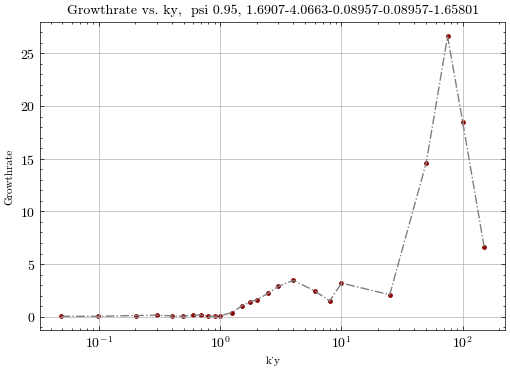

In [52]:
# Function to parse the log file
def parse_log_file(filepath):
    parsed_data = []
    with open(filepath, 'r') as file:
        lines = file.readlines()[1:] 
        for line in lines:
            if line.strip():  # Make sure to skip any empty lines
                parts = [x.strip() for x in line.split('|')]
                eigenvalues = parts[3].split()
                x0 = float(parts[0])
                k_y = float(parts[1])
                growthrate = float(eigenvalues[0])
                frequency = float(eigenvalues[1])
                parsed_data.append([k_y, x0, growthrate, frequency])
    return pd.DataFrame(parsed_data, columns=['x0', 'k_y', 'growthrate', 'frequency'])

def parse_log_file2(filepath):
    parsed_data = []
    with open(filepath, 'r') as file:
        # Skipping the header line
        next(file)
        for line in file:
            if line.strip():  # Make sure to skip any empty lines
                parts = [x.strip() for x in line.split('|')]
                if len(parts) > 3:  # Ensure there are enough parts in the line
                    run_id = parts[0]
                    x0 = float(parts[1])
                    k_y = float(parts[2])
                    eigenvalues = parts[3].split()
                    if len(eigenvalues) == 2:  # Ensure there are exactly two eigenvalues
                        growth_rate = float(eigenvalues[0])
                        frequency = float(eigenvalues[1])
                        parsed_data.append([x0, k_y, growth_rate, frequency])

    return pd.DataFrame(parsed_data, columns=['x0', 'k_y', 'growth_rate', 'frequency'])

# Reading and parsing the data
scanlog_path = "/scratch/project_462000451/daniel/sprint_out/gene/full_test/1.0-1.8-3.0-4.4-0.05-0.1-0.5-2.8/1.6907219221235361-4.066386570204081-0.08957719078481746-0.08957719078481746-1.6580178585501517/scanfiles0001/scan.log"
df = parse_log_file2(scanlog_path)
#df2 = parse_log_file(scanlog_path2)
# Plotting the data
plt.figure(figsize=(6, 4))
plt.scatter(df.query('x0==0.95')['k_y'], df.query('x0==0.95')['growth_rate'], c = 'darkred', s = 6)
plt.plot(df.query('x0==0.95')['k_y'], df.query('x0==0.95')['growth_rate'], c = 'grey', linestyle = '-.')

#plt.plot(df2['k_y'], df2['growthrate'], c = 'black', label= "CHEASE eqdsk")
plt.xscale('log')
plt.xlabel('k_y', fontsize = 8)
plt.ylabel('Growthrate', fontsize = 8)
plt.title('Growthrate vs. ky,  psi 0.95, 1.6907-4.0663-0.08957-0.08957-1.65801', fontsize = 10)
plt.legend()
#plt.xlim(0, 2)
#plt.ylim(-0.2, 2)
plt.grid(True)
plt.show()

['1.55-3.6500000000000004-0.05500000000000001-0.05500000000000001-1.85', '2.0-3.6500000000000004-0.05500000000000001-0.05500000000000001-1.85']


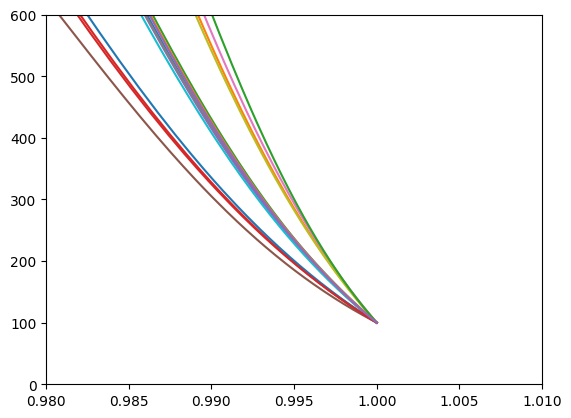

In [17]:
import matplotlib.pyplot as plt

print(hel_output_names[0:2])
for name_path in hel_output_names:
    filepath = os.path.join(base_run_dir, name_path, "eliteinp")
    elite_data = hp.read_eliteinput(filepath)
    #plt.plot( eliteinp["Psi"], eliteinp["ne"])
    psi = elite_data["Psi"]
    nx = len(psi)
    te = elite_data["Te"]
    ti = elite_data["Ti"]
    ne = elite_data["ne"]
    q = elite_data["q"]
    q_cd = 0.5 * (q[:-1] + q[1:])
    dpsi = np.diff(psi)
    dphit = q_cd * dpsi
    phit = np.cumsum(dphit)
    phitt = np.concatenate(([0], phit))
    rhot = np.sqrt(phitt / np.max(phitt))

    plt.plot(rhot, elite_data["Te"])
    plt.ylim(0, 600)
    plt.xlim(0.98, 1.01)
    plt.show


# Run Enchanted surrogates, Not woking

In [1]:
import os
os.chdir('/project/project_462000451/enchanted-surrogates/')
os.system('bash run_lumi.bash')

The following modules were not unloaded:
  (Use "module --force purge" to unload all):

  1) ModuleLabel/label   2) lumi-tools/24.05   3) init-lumi/0.2

The following sticky modules could not be reloaded:

  1) lumi-tools


helena_config_beta_noKBM_lumi.yaml
Cannot find bmdal_reg. Please point to those in your bash script if you intend to use ActiveLearnerBMDAL No module named 'bmdal_reg'
Cannot find DREAM. Please add the $DREAMPATH/py to your PYTHONPATH environment variable before running. No module named 'DREAM'
POINTS SHAPE (21, 5)
 no points for dim = 5 and level = 3 is n = 21
Starting Setup
Making directory of simulations at: /scratch/project_462000451/daniel/sprint_out/helena, and copying /pfs/lustrep4/projappl/project_462000451/enchanted-surrogates/configs/helena_config_beta_noKBM_lumi.yaml to CONFIG.yaml
Beginning SLURMCluster Generation
Initializing DASK clients
Finished Setup
Creating initial runs
Generating Samples:
Making Dask Futures
Sampler is SEQUENTIAL
single_code_run: /scratch/project_462000451/daniel/sprint_out/helena/4a025eef-5d72-4dd5-8222-d265bdda7cf6
single_code_run: /scratch/project_462000451/daniel/sprint_out/helena/3aa18b80-8315-4d1b-9191-1938808b818e
single_code_run: /scratch/pro

Traceback (most recent call last):
  File "/pfs/lustrep4/projappl/project_462000451/enchanted-surrogates/src/run.py", line 53, in <module>
    main(args)
  File "/pfs/lustrep4/projappl/project_462000451/enchanted-surrogates/src/run.py", line 38, in main
    executor.start_runs()
  File "/pfs/lustrep4/projappl/project_462000451/enchanted-surrogates/src/executors/DaskExecutor.py", line 127, in start_runs
    res = future.result()
          ^^^^^^^^^^^^^^^
  File "/project/project_462000451/enchanted_container_lumi3/lib/python3.11/site-packages/distributed/client.py", line 401, in result
    return self.client.sync(self._result, callback_timeout=timeout)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/pfs/lustrep4/projappl/project_462000451/enchanted-surrogates/src/executors/base.py", line 49, in run_simulation_task
    runner_output = runner.single_code_run(params_from_sampler, run_dir)
      ^^^^^^^^^^^^^^^^^
  File "/pfs/lustrep4/projappl/project_462000451/

256